In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
%config Completer.use_jedi = False

In [3]:
# 导入各种必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy
# 当只有一个数据集的时候用这个做train和test的划分，由于kaggle已经分好了，所以不用
from sklearn.model_selection import train_test_split
# 特征缩放
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
print(torch.cuda.is_available())

True


In [5]:
# 加载数据
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

print(train_data.head())
print(test_data.head())
print(train_data.shape)
print(test_data.shape)

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

In [6]:
# 检查缺失值
missing_train = train_data.isnull().sum()
missing_test = test_data.isnull().sum()
for m_train, m_test in zip(train_data.columns, test_data.columns):
    print(f"{m_train}: {train_data[m_train].dtype}, missing: {missing_train[m_train]}")
    print(f"{m_test}: {test_data[m_test].dtype}, missing: {missing_test[m_test]}")

PassengerId: int64, missing: 0
PassengerId: int64, missing: 0
Survived: int64, missing: 0
Pclass: int64, missing: 0
Pclass: int64, missing: 0
Name: object, missing: 0
Name: object, missing: 0
Sex: object, missing: 0
Sex: object, missing: 0
Age: float64, missing: 86
Age: float64, missing: 177
SibSp: int64, missing: 0
SibSp: int64, missing: 0
Parch: int64, missing: 0
Parch: int64, missing: 0
Ticket: object, missing: 0
Ticket: object, missing: 0
Fare: float64, missing: 1
Fare: float64, missing: 0
Cabin: object, missing: 327
Cabin: object, missing: 687
Embarked: object, missing: 0


<function matplotlib.pyplot.show(close=None, block=None)>

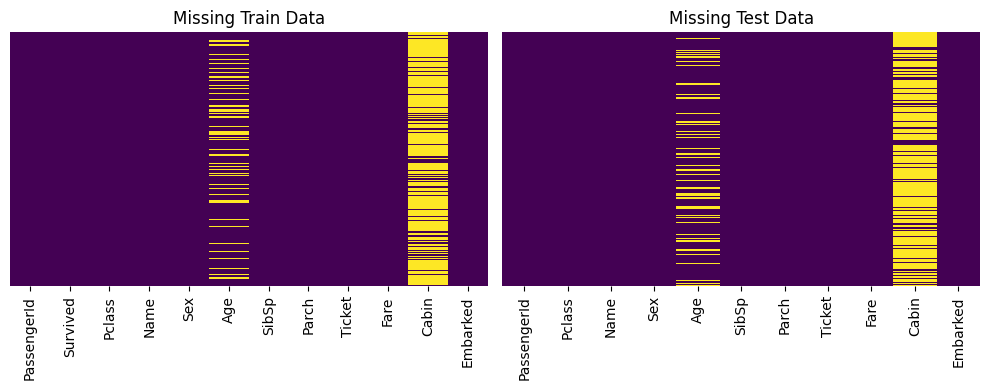

In [7]:
# 展示缺失值
missing_train = train_data.isnull()
missing_test = test_data.isnull()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(missing_train, cbar=False, yticklabels=False, cmap='viridis', ax=ax[0])
ax[0].set_title("Missing Train Data")

sns.heatmap(missing_test, cbar=False, yticklabels=False, cmap='viridis', ax=ax[1])
ax[1].set_title("Missing Test Data")

plt.tight_layout()
plt.show

In [8]:
# 合并训练集和测试集
print("train_data.shape: ", train_data.shape)
print("test_data.shape: ", test_data.shape)

# 找出二者有差异的列
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)
print(train_columns)
print(test_columns)
print(train_columns - test_columns)

train_data.shape:  (891, 12)
test_data.shape:  (418, 11)
{'SibSp', 'Pclass', 'Parch', 'Fare', 'Ticket', 'Survived', 'PassengerId', 'Cabin', 'Sex', 'Age', 'Embarked', 'Name'}
{'SibSp', 'Pclass', 'Parch', 'Fare', 'Ticket', 'PassengerId', 'Cabin', 'Sex', 'Age', 'Embarked', 'Name'}
{'Survived'}


In [9]:
# survived单独拿出来，其他的合并处理缺失
train_labels = torch.tensor(train_data.Survived.values.reshape(-1,1), dtype=int)
print("train_labels: \n", train_labels[:5])

# 合并数据,合并即可，不需要axis
# 同时把passengerID这种唯一标识符drop掉，不然会导致模型直接记住结果
all_features = pd.concat((train_data.drop(columns=['Survived']), test_data))
print("all_features.shape: ", all_features.shape)

train_labels: 
 tensor([[0],
        [1],
        [1],
        [1],
        [0]])
all_features.shape:  (1309, 11)


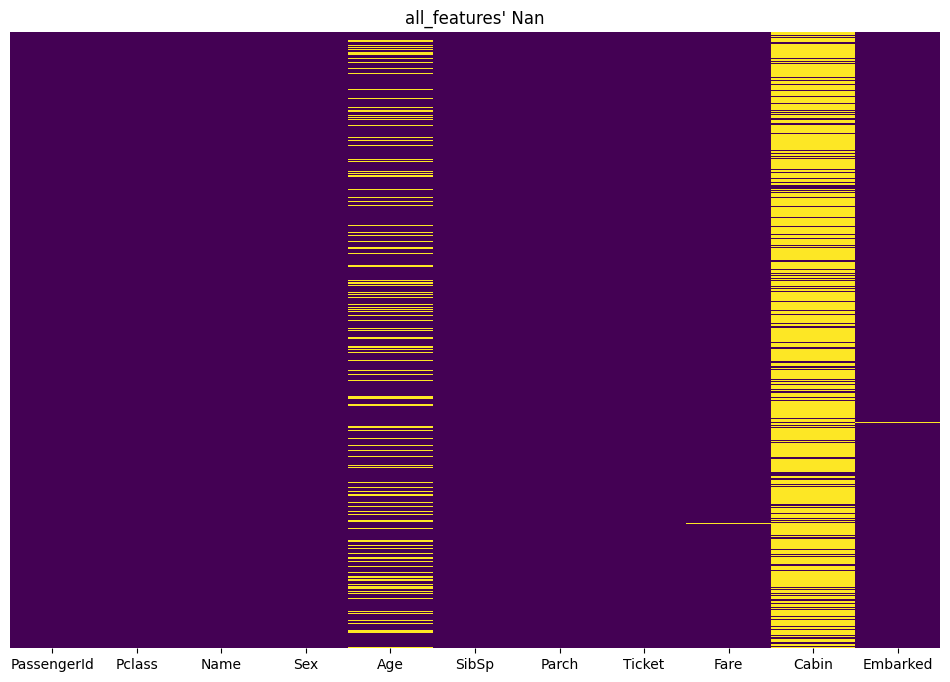

In [10]:
# 展示合并过后的缺失值
missing_value = all_features.isnull()
plt.figure(figsize=(12, 8))
sns.heatmap(missing_value, cbar=False, yticklabels=False, cmap='viridis')
plt.title("all_features' Nan")
plt.show()

In [11]:
# 可以看到缺失值既有数值型缺失值，又有非数值型缺失值，分别处理
# 处理数值型缺失值
missing_column = all_features.columns[all_features.isnull().any()].tolist()
print("missing_column: ", missing_column)
numeric_missing = [col for col in missing_column if pd.api.types.is_numeric_dtype(all_features[col])]
print(f"numeric missing: {numeric_missing}")
for col in numeric_missing:
    all_features[col].fillna(all_features[col].median(), inplace=True)
print(f"numeric missing: {numeric_missing}")
# 处理非数值型 - 独热编码
all_features = pd.get_dummies(all_features, dummy_na=True)
print(f"all_feature.shape: {all_features.shape}")

missing_column:  ['Age', 'Fare', 'Cabin', 'Embarked']
numeric missing: ['Age', 'Fare']
numeric missing: ['Age', 'Fare']
all_feature.shape: (1309, 2438)


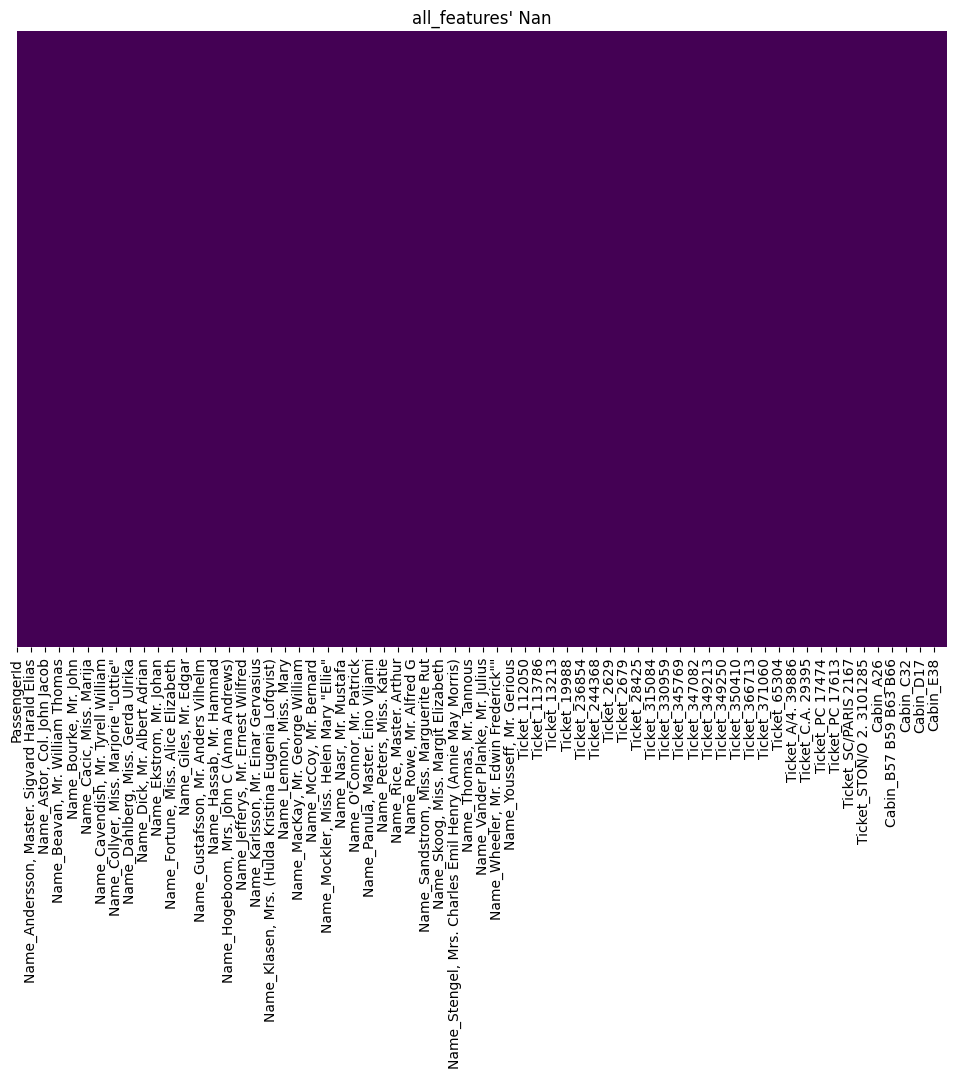

In [12]:
# 展示处理过后all_features的缺失值
missing_value = all_features.isnull()
plt.figure(figsize=(12, 8))
sns.heatmap(missing_value, cbar=False, yticklabels=False, cmap='viridis')
plt.title("all_features' Nan")
plt.show()

In [13]:
# 数据的缺失值处理完毕，开始拆分训练集和测试集
print(f"train.shape[0] - 训练集的条目个数: {train_data.shape[0]}")
n_train = train_data.shape[0]
# 提取DataFrame中的前n行并通过values保留数据，同时
print(all_features[:n_train].values)
print(type(all_features[:n_train].values))

# get_dummies不会把True或者False转换成独热编码
# 把numpy中的bool值转换成0/1的形式
all_features = all_features.astype(int)
print(all_features[:n_train].values)

train.shape[0] - 训练集的条目个数: 891
[[1 3 22.0 ... False True False]
 [2 1 38.0 ... False False False]
 [3 3 26.0 ... False True False]
 ...
 [889 3 28.0 ... False True False]
 [890 1 26.0 ... False False False]
 [891 3 32.0 ... True False False]]
<class 'numpy.ndarray'>
[[  1   3  22 ...   0   1   0]
 [  2   1  38 ...   0   0   0]
 [  3   3  26 ...   0   1   0]
 ...
 [889   3  28 ...   0   1   0]
 [890   1  26 ...   0   0   0]
 [891   3  32 ...   1   0   0]]


In [14]:
# 划分训练集和测试集
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
print(train_features[:5])
print(test_features[:5])
print(f"train_features.shape: {train_features.shape}")
print(f"test_features.shape: {test_features.shape}")
print(f"train_labels.shape: {train_labels.shape}")
print(f"trian_labels:\n {train_labels[:5]}")

tensor([[ 1.,  3., 22.,  ...,  0.,  1.,  0.],
        [ 2.,  1., 38.,  ...,  0.,  0.,  0.],
        [ 3.,  3., 26.,  ...,  0.,  1.,  0.],
        [ 4.,  1., 35.,  ...,  0.,  1.,  0.],
        [ 5.,  3., 35.,  ...,  0.,  1.,  0.]])
tensor([[892.,   3.,  34.,  ...,   1.,   0.,   0.],
        [893.,   3.,  47.,  ...,   0.,   1.,   0.],
        [894.,   2.,  62.,  ...,   1.,   0.,   0.],
        [895.,   3.,  27.,  ...,   0.,   1.,   0.],
        [896.,   3.,  22.,  ...,   0.,   1.,   0.]])
train_features.shape: torch.Size([891, 2438])
test_features.shape: torch.Size([418, 2438])
train_labels.shape: torch.Size([891, 1])
trian_labels:
 tensor([[0],
        [1],
        [1],
        [1],
        [0]])


In [15]:
# 分批次读入数据
# 每批数据40个元素
batch_size = 40
dataset = torch.utils.data.TensorDataset(train_features, train_labels)
print(f"type of dataset: {type(dataset)}")
print(f"dataset: {dataset[:5]}")


# pin_memory - 数据加载器在返回批次之前，将数据复制到CUDA中
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
print(f"type of train_loader: {type(train_loader)}")

print(f"Total number of batches: {len(train_loader)}")
for i, (data, labels) in enumerate(train_loader):
    print(f"Batch {i+1} contains {data.size(0)} samples, {len(labels)} labels")

type of dataset: <class 'torch.utils.data.dataset.TensorDataset'>
dataset: (tensor([[ 1.,  3., 22.,  ...,  0.,  1.,  0.],
        [ 2.,  1., 38.,  ...,  0.,  0.,  0.],
        [ 3.,  3., 26.,  ...,  0.,  1.,  0.],
        [ 4.,  1., 35.,  ...,  0.,  1.,  0.],
        [ 5.,  3., 35.,  ...,  0.,  1.,  0.]]), tensor([[0],
        [1],
        [1],
        [1],
        [0]]))
type of train_loader: <class 'torch.utils.data.dataloader.DataLoader'>
Total number of batches: 23
Batch 1 contains 40 samples, 40 labels
Batch 2 contains 40 samples, 40 labels
Batch 3 contains 40 samples, 40 labels
Batch 4 contains 40 samples, 40 labels
Batch 5 contains 40 samples, 40 labels
Batch 6 contains 40 samples, 40 labels
Batch 7 contains 40 samples, 40 labels
Batch 8 contains 40 samples, 40 labels
Batch 9 contains 40 samples, 40 labels
Batch 10 contains 40 samples, 40 labels
Batch 11 contains 40 samples, 40 labels
Batch 12 contains 40 samples, 40 labels
Batch 13 contains 40 samples, 40 labels
Batch 14 contai

In [16]:
# 定义神经网络模型
class Titanic(torch.nn.Module):
    def __init__(self, in_put, h1, h2, out):
        super().__init__()
        self.linear1 = torch.nn.Linear(in_put, h1)
        self.linear2 = torch.nn.Linear(h1, h2)
        self.linear3 = torch.nn.Linear(h2, out)
        
    def forward(self, data):
        x = self.linear1(data)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x)
        return x

In [17]:
# 输入的个数应该是列数 - 每一轮读一行即一个数据
in_put = train_features.shape[1]
print(in_put)
h1, h2, out = 200, 200, 1
model = Titanic(in_put, h1, h2, out).to("cuda")
print(model)

2438
Titanic(
  (linear1): Linear(in_features=2438, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=1, bias=True)
)


In [18]:
loss = torch.nn.MSELoss()
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr)

In [19]:
print(train_loader)
i = 0
for train_batch, labels_batch in train_loader:
    if i == 3: break 
    i += 1
    print(train_batch.size())
    print(train_batch, labels_batch)

torch.Size([40, 2438])
tensor([[800.,   3.,  30.,  ...,   0.,   1.,   0.],
        [415.,   3.,  44.,  ...,   0.,   1.,   0.],
        [629.,   3.,  26.,  ...,   0.,   1.,   0.],
        ...,
        [573.,   1.,  36.,  ...,   0.,   1.,   0.],
        [172.,   3.,   4.,  ...,   1.,   0.,   0.],
        [158.,   3.,  30.,  ...,   0.,   1.,   0.]]) tensor([[0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0]])
torch.Size([40, 2438])
tensor([[275.,   3.,  28.,  ...,   1.,   0.,   0.],
        [437.,   3.,  21.,  ...,   0.,   1.,   0.],
   

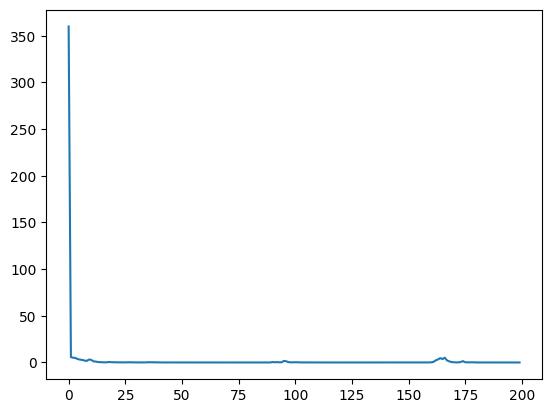

In [20]:
epochs = 200
def train(train_loader):
    train_loss = []
    for epoch in range(epochs):
        loss_sum = 0
        for train_batch, labels_batch in train_loader:
            train_batch, labels_batch = train_batch.float().to("cuda"), labels_batch.float().to("cuda")
            # 计算损失值
            l = loss(model(train_batch), labels_batch)
            # 梯度清零
            optimizer.zero_grad()
            # 反向传播
            l.backward()
            # 更新参数
            optimizer.step()
            # 累加损失
            loss_sum += l.item()
        train_loss.append(loss_sum)
    plt.plot(range(epochs), train_loss)
    plt.show()
train(train_loader)

In [21]:
# 模型训练完毕 可以拿来做预测了
csvfile = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
csvfile = csvfile.drop(columns=['Survived'])
print(csvfile)
def test(test_features):
    test_features = test_features.to('cuda')
    # detach - 创建一个新的张量和原始计算图中的张量共享数据，不需要梯度，不会更新
    preds = model(test_features).detach().to('cpu')
    # 预测概率大于0.5认为生还，小于0.5认为死亡
    res = (preds > 0.5).float().int().numpy()
    print(res.squeeze())
    return pd.concat([csvfile['PassengerId'], pd.DataFrame(res, columns=['Survived'])], axis=1)
    
submission = test(test_features)
print(submission)
submission.to_csv("submission.csv", index=False)

     PassengerId
0            892
1            893
2            894
3            895
4            896
..           ...
413         1305
414         1306
415         1307
416         1308
417         1309

[418 rows x 1 columns]
[0 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1
 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0
 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0
 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0